In [1]:
import sys, os
sys.path.insert(0, '../../')
sys.path.insert(0, '../../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [2]:
gray = "#969696"
blue = "#377eb8"
red = "#e41a1c"


def show_network(ax, net, disp=None, strain=None, styles={}):

        
    boxsize=0.5
    padding=0.0
    
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    center = 0.5 * np.ones(DIM, float)
    
    
    if disp is None:
        disp = np.zeros(DIM*NN, float)
    
    if strain is None:
        strain = np.zeros([DIM, DIM], float)
    else:
        boxL = 0.5 + padding
        corners = np.array([[-boxL, -boxL], 
                            [boxL, -boxL], 
                            [boxL, boxL], 
                            [-boxL, boxL]])
        corners[0] = def_tensor[0:2, 0:2].dot(corners[0])
        corners[1] = def_tensor[0:2, 0:2].dot(corners[1])
        corners[2] = def_tensor[0:2, 0:2].dot(corners[2])
        corners[3] = def_tensor[0:2, 0:2].dot(corners[3])

        ax.add_patch(mpatches.Polygon(corners, True, fill=False, lw=4.0))

    patches = []


    def_tensor = np.identity(DIM) + strain 



    for i in range(NN):
        node_pos[DIM*i:DIM*i+DIM] += padding * L
    
    L += 2.0 * padding * L
    
    edges = []
    edge_index = []
    
    #change to showing 9 copies of networks

    for i in range(NE):
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]+disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]+disp[DIM*edgej[i]:DIM*edgej[i]+DIM]

        posi /= L
        posj /= L

        bvec = posj - posi
        bvec -= np.rint(bvec)

        posi -= np.floor(posi)
        posj -= np.floor(posj)

        posi -= center
        posj -= center
        
        
        edges.append([tuple(posi),tuple(posi+bvec)])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([1.0, 0.0])),tuple(posi+bvec+np.array([1.0, 0.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([1.0, -1.0])),tuple(posi+bvec+np.array([1.0, -1.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([0.0, -1.0])),tuple(posi+bvec+np.array([0.0, -1.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([-1.0, -1.0])),tuple(posi+bvec+np.array([-1.0, -1.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([-1.0, 0.0])),tuple(posi+bvec+np.array([-1.0, 0.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([-1.0, 1.0])),tuple(posi+bvec+np.array([-1.0, 1.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([0.0, 1.0])),tuple(posi+bvec+np.array([0.0, 1.0]))])    
        edge_index.append(i)
        
        edges.append([tuple(posi+np.array([1.0, 1.0])),tuple(posi+bvec+np.array([1.0, 1.0]))])    
        edge_index.append(i)


    for i, b in enumerate(edges):
        edges[i] = [def_tensor.dot(b[0])[0:2], def_tensor.dot(b[1])[0:2]]
    
    ls = []
    colors = []
    lw = []
    
    for i, b in enumerate(edge_index):
        
        if b in styles and 'color' in styles[b]:
            colors.append(styles[b]['color'])
        else:
            colors.append(gray)
            
            
        if b in styles and 'ls' in styles[b]:
            ls.append(styles[b]['ls'])
        else:
            ls.append('solid')
            
        if b in styles and 'lw' in styles[b]:
            lw.append(styles[b]['lw'])
        else:
            lw.append(2.0)
                    
    
    lc = mc.LineCollection(edges, zorder=-1, linestyle=ls, lw=lw, alpha=0.8, color=colors)  
    ax.add_collection(lc)
    
    ax.set_xlim(-boxsize, boxsize)
    ax.set_ylim(-boxsize, boxsize)
    
    
def show_nodes(ax, net, nodes, disp=None, strain=None, styles={}, marker='o'):
    
    
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    center = 0.5 * np.ones(DIM, float)
    
    if disp is None:
        disp = np.zeros(DIM*NN, float)
    
    if strain is None:
        strain = np.zeros([DIM, DIM], float)

    def_tensor = np.identity(DIM) + strain 
        
    x1 = []
    y1 = []

    for i in range(len(nodes)):
        
        posi = node_pos[DIM*nodes[i]:DIM*nodes[i]+DIM]+disp[DIM*nodes[i]:DIM*nodes[i]+DIM]

        posi /= L

        posi -= np.floor(posi)

        posi -= center

        posi = def_tensor.dot(posi)

        x1.append(posi[0])
        y1.append(posi[1])

    colors = []
    sizes = []

    for b in nodes:
        
        if b in styles and 'color' in styles[b]:
            colors.append(styles[b]['color'])
        else:
            colors.append('k')
            
        if b in styles and 'size' in styles[b]:
            sizes.append(styles[b]['size'])
        else:
            sizes.append(200)
                        
    ax.scatter(x1, y1, marker=marker , s=sizes, facecolor=colors, alpha=1.0)

def show_vecs(ax, net, disp, strain=None):
    
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    center = 0.5 * np.ones(DIM, float)
        
    if strain is None:
        strain = np.zeros([DIM, DIM], float)

    def_tensor = np.identity(DIM) + strain 
    
    X = np.zeros(NN, float)
    Y = np.zeros(NN, float)
    U = np.zeros(NN, float)
    V = np.zeros(NN, float)
    
    for i in range(NN):
        
        pos = node_pos[DIM*i:DIM*i+DIM]

        pos /= L

        pos -= np.floor(pos)

        pos -= center
        
        pos = def_tensor.dot(pos)
        
        u = disp[DIM*i:DIM*i+DIM]
        u /= L
        
        X[i] = pos[0]
        Y[i] = pos[1]
        U[i] = u[0]
        V[i] = u[1]
        
    ax.quiver(X, Y, U, V, units='xy', angles='xy', scale_units='xy', scale=1.0/2.0)
    
        
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext
      

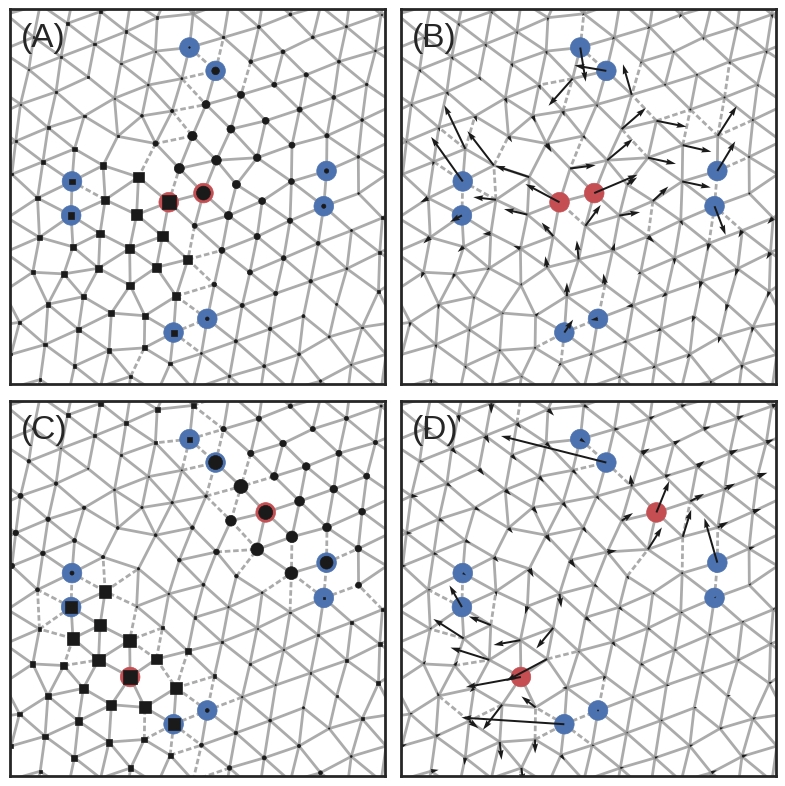

In [15]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.25)
sns.set_palette("Set1", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})
fig = plt.figure(figsize=(8,8))


# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['mathtext.fontset'] = 'cm'
# sns.set(color_codes=True)
# sns.set_context('paper', font_scale=1.5)
# sns.set_palette("Set1", 8)
# # sns.set_palette("muted", 8)
# sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})
# fig = plt.figure(figsize=(6,6))

    
ax1 = fig.add_subplot(2, 2, 1, aspect=1.0)
ax2 = fig.add_subplot(2, 2, 2, aspect=1.0)
ax3 = fig.add_subplot(2, 2, 3, aspect=1.0)
ax4 = fig.add_subplot(2, 2, 4, aspect=1.0)



#######################################

with open("network_1D_edge.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']
    net1d = network.convertToFlowNetwork(net) 
    
# delta_ext =  (calc_ext(net1d, disp) - calc_ext(net1d, disp_init)) / calc_ext(net1d, disp_init)


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

# print np.min(delta_ext), np.max(delta_ext)
# norm = mcolors.Normalize(vmin=-1, vmax=1)
# cmap = mpl.cm.viridis
# m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# for edge in range(net.NE):
#     styles[edge]['color'] = m.to_rgba(delta_ext[edge])

    
show_network(ax1, net, styles=styles)



styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax1, net, styles.keys(), styles=styles)



styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
show_nodes(ax1, net, styles.keys(), styles=styles, marker='s')

styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
show_nodes(ax1, net, styles.keys(), styles=styles, marker='o')




#######################################

with open("network_2D_edge.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']



with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 
    
delta_ext =  (calc_ext(net, disp) - calc_ext(net, disp_init)) / calc_ext(net, disp_init)

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

# print np.min(delta_ext), np.max(delta_ext)
# norm = mcolors.Normalize(vmin=-1, vmax=1)
# cmap = mpl.cm.viridis
# m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# for edge in range(net.NE):
#     styles[edge]['color'] = m.to_rgba(delta_ext[edge])

    
show_network(ax2, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax2, net, styles.keys(), styles=styles)
show_vecs(ax2, net, disp)



#######################################


with open("network_1D_nodepair.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']
    net1d = network.convertToFlowNetwork(net) 
    
# delta_ext =  (calc_ext(net1d, disp) - calc_ext(net1d, disp_init)) / calc_ext(net1d, disp_init)


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

# print np.min(delta_ext), np.max(delta_ext)
# norm = mcolors.Normalize(vmin=-1, vmax=1)
# cmap = mpl.cm.viridis
# m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# for edge in range(net.NE):
#     styles[edge]['color'] = m.to_rgba(delta_ext[edge])

    
show_network(ax3, net, styles=styles)



styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax3, net, styles.keys(), styles=styles)



styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
show_nodes(ax3, net, styles.keys(), styles=styles, marker='s')

styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
show_nodes(ax3, net, styles.keys(), styles=styles, marker='o')


#######################################


with open("network_2D_nodepair.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']


with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 
    
delta_ext =  (calc_ext(net, disp) - calc_ext(net, disp_init)) / calc_ext(net, disp_init)

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))


# for edge in range(net.NE):
#     styles[edge]['color'] = m.to_rgba(delta_ext[edge])

    
show_network(ax4, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax4, net, styles.keys(), styles=styles)
show_vecs(ax4, net, disp)



#######################################

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])


ax1.text(0.03, 0.9, '(A)', transform=ax1.transAxes)
ax2.text(0.03, 0.9, '(B)', transform=ax2.transAxes)
ax3.text(0.03, 0.9, '(C)', transform=ax3.transAxes)
ax4.text(0.03, 0.9, '(D)', transform=ax4.transAxes)

# ax5 = fig.add_axes([1.0, 0.05, 0.03, 0.90])


# cbar = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cbar.set_label(r'$\Delta \eta / \eta_0$')
# cbar.ax.tick_params(labelsize=20)

fig.tight_layout(pad=0.5)

plt.savefig("figure1.pdf")

plt.show()

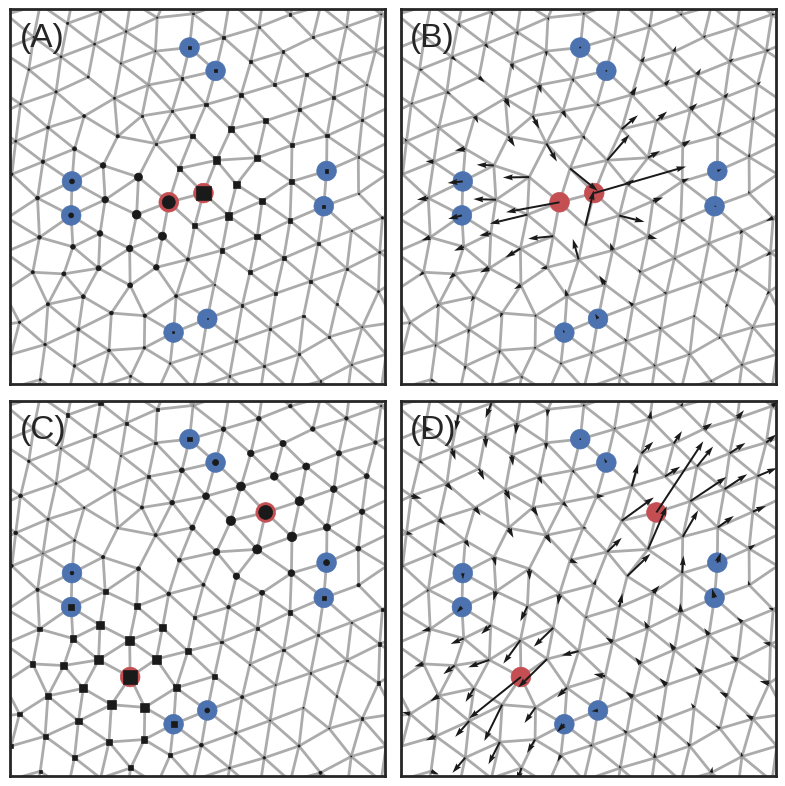

In [11]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.25)
sns.set_palette("Set1", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))

    
ax1 = fig.add_subplot(2, 2, 1, aspect=1.0)
ax2 = fig.add_subplot(2, 2, 2, aspect=1.0)
ax3 = fig.add_subplot(2, 2, 3, aspect=1.0)
ax4 = fig.add_subplot(2, 2, 4, aspect=1.0)



#######################################

with open("network_1D_edge.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']
    net1d = network.convertToFlowNetwork(net) 
    
# delta_ext =  (calc_ext(net1d, disp) - calc_ext(net1d, disp_init)) / calc_ext(net1d, disp_init)


styles = {edge: {} for edge in range(net.NE)}

    
show_network(ax1, net, styles=styles)



styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax1, net, styles.keys(), styles=styles)



styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp_init[node])
        
show_nodes(ax1, net, styles.keys(), styles=styles, marker='s')

styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp_init[node])
        
show_nodes(ax1, net, styles.keys(), styles=styles, marker='o')




#######################################

with open("network_2D_edge.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']



with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 
    
delta_ext =  (calc_ext(net, disp) - calc_ext(net, disp_init)) / calc_ext(net, disp_init)

styles = {edge: {} for edge in range(net.NE)}

    
show_network(ax2, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax2, net, styles.keys(), styles=styles)
show_vecs(ax2, net, disp_init)



#######################################


with open("network_1D_nodepair.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']
    net1d = network.convertToFlowNetwork(net) 
    
# delta_ext =  (calc_ext(net1d, disp) - calc_ext(net1d, disp_init)) / calc_ext(net1d, disp_init)


styles = {edge: {} for edge in range(net.NE)}

show_network(ax3, net, styles=styles)



styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax3, net, styles.keys(), styles=styles)



styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp_init[node])
        
show_nodes(ax3, net, styles.keys(), styles=styles, marker='s')

styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp_init[node])
        
show_nodes(ax3, net, styles.keys(), styles=styles, marker='o')


#######################################


with open("network_2D_nodepair.pkl", 'rb') as pkl_file:
    data = pickle.load(pkl_file)
        
nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']
disp_init = data['disp_init']


with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 
    
delta_ext =  (calc_ext(net, disp) - calc_ext(net, disp_init)) / calc_ext(net, disp_init)

styles = {edge: {} for edge in range(net.NE)}
    
show_network(ax4, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

show_nodes(ax4, net, styles.keys(), styles=styles)
show_vecs(ax4, net, disp_init)



#######################################

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

ax1.text(-0.475, 0.40, '(A)')
ax2.text(-0.475, 0.40, '(B)')
ax3.text(-0.475, 0.40, '(C)')
ax4.text(-0.475, 0.40, '(D)')


# ax5 = fig.add_axes([1.0, 0.05, 0.03, 0.90])


# cbar = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cbar.set_label(r'$\Delta \eta / \eta_0$')
# cbar.ax.tick_params(labelsize=20)

fig.tight_layout(pad=0.5)

plt.show()

In [3]:
DIM = 2

NTS = 4

NN = 128
Lp = -1.0
irec = 0

eta = 50.0

NDISC = 1.0

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################

L = np.copy(net.L)

s = network.closestEdge(net, 0.5*L)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

t1 = network.closestEdge(net, np.array([0.85*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t1])
onodesj[0].append(edgej[t1])
ostrain_bonds[0].append(t1)

t2 = network.closestEdge(net, np.array([0.15*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t2])
onodesj[0].append(edgej[t2])
ostrain_bonds[0].append(t2)


t3 = network.closestEdge(net, np.array([0.5*L[0], 0.15*L[1]]))[0]
onodesi[0].append(edgei[t3])
onodesj[0].append(edgej[t3])
ostrain_bonds[0].append(t3)

t4 = network.closestEdge(net, np.array([0.5*L[0], 0.85*L[1]]))[0]
onodesi[0].append(edgei[t4])
onodesj[0].append(edgej[t4])
ostrain_bonds[0].append(t4)


######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds


tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

with open("network_2D_edge.pkl", 'wb') as pkl_file:
    pickler = pickle.Pickler(pkl_file, -1)
        
    pickler.dump(data)

Initial objective function: 5000.0
Removing 0 / 350.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 283}
0 Objective function: 4842.02074483 Change: -157.97925517 Percent: -0.0315958510341
Previous: 6 4
Current: 5 3
Removing 0 / 349.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 180}
1 Objective function: 4702.49132693 Change: -139.529417899 Percent: -0.0288163610302
Previous: 5 5
Current: 4 4
Removing 0 / 348.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 122}
2 Objective function: 4467.46333764 Change: -235.027989294 Percent: -0.0499794625773
Previous: 4 6
Current: 3 5
Removing 0 / 347.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 334}
3 Objective function: 4274.31360626 Change: -193.149731378 Percent: -0.0432347658571
Previous: 5 6
Current: 4 5
Removing 0 / 346.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 167}
4 Objective function: 4066.00261242 Change: -208.31099384 Percent: -0.0487355428331
Previous:

In [4]:
DIM = 2

NTS = 4

NN = 128
Lp = -1.0
irec = 0

eta = 50.0

NDISC = 1.0

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################


L = np.copy(net.L)

inodesi[0].append(network.chooseNodesPos(net, 0.70*L)[0])
inodesj[0].append(network.chooseNodesPos(net, 0.30*L)[0])


t1 = network.closestEdge(net, np.array([0.85*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t1])
onodesj[0].append(edgej[t1])
ostrain_bonds[0].append(t1)

t2 = network.closestEdge(net, np.array([0.15*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t2])
onodesj[0].append(edgej[t2])
ostrain_bonds[0].append(t2)


t3 = network.closestEdge(net, np.array([0.5*L[0], 0.15*L[1]]))[0]
onodesi[0].append(edgei[t3])
onodesj[0].append(edgej[t3])
ostrain_bonds[0].append(t3)

t4 = network.closestEdge(net, np.array([0.5*L[0], 0.85*L[1]]))[0]
onodesi[0].append(edgei[t4])
onodesj[0].append(edgej[t4])
ostrain_bonds[0].append(t4)


######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds

tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

with open("network_2D_nodepair.pkl", 'wb') as pkl_file:
    pickler = pickle.Pickler(pkl_file, -1)
        
    pickler.dump(data)

Initial objective function: 5000.0
Removing 0 / 350.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 283}
0 Objective function: 4843.92634815 Change: -156.073651851 Percent: -0.0312147303702
Previous: 6 4
Current: 5 3
Removing 0 / 349.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 318}
1 Objective function: 4532.51316557 Change: -311.413182584 Percent: -0.064289413216
Previous: 5 6
Current: 4 5
Removing 0 / 348.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 309}
2 Objective function: 3914.89093499 Change: -617.622230578 Percent: -0.136264850871
Previous: 3 6
Current: 2 5
Removing 2 / 347.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 290}
3 Objective function: 3695.12306307 Change: -219.767871922 Percent: -0.056136397047
Previous: 4 6
Current: 3 5
Removing 2 / 346.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 96}
4 Objective function: 3452.01456407 Change: -243.108498997 Percent: -0.0657917192061
Previous: 6

In [3]:
DIM = 1

NTS = 4

NN = 128
Lp = -1.0
irec = 0

eta = 10.0

NDISC = 1.0

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net2d = nw_data['network']
    net = network.convertToFlowNetwork(net2d)   


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################

L = np.copy(net2d.L)

s = network.closestEdge(net2d, 0.5*L)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

t1 = network.closestEdge(net2d, np.array([0.85*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t1])
onodesj[0].append(edgej[t1])
ostrain_bonds[0].append(t1)

t2 = network.closestEdge(net2d, np.array([0.15*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t2])
onodesj[0].append(edgej[t2])
ostrain_bonds[0].append(t2)


t3 = network.closestEdge(net2d, np.array([0.5*L[0], 0.15*L[1]]))[0]
onodesi[0].append(edgei[t3])
onodesj[0].append(edgej[t3])
ostrain_bonds[0].append(t3)

t4 = network.closestEdge(net2d, np.array([0.5*L[0], 0.85*L[1]]))[0]
onodesi[0].append(edgei[t4])
onodesj[0].append(edgej[t4])
ostrain_bonds[0].append(t4)


######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_max = np.ones(net.NE, float)

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds


tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

with open("network_1D_edge.pkl", 'wb') as pkl_file:
    pickler = pickle.Pickler(pkl_file, -1)
        
    pickler.dump(data)

Initial objective function: 200.0
Removing 0 / 350.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 97}
0 Objective function: 136.3951551 Change: -63.6048448996 Percent: -0.318024224498
Previous: 6 5
Current: 5 4
Removing 0 / 349.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 100}
1 Objective function: 103.933693799 Change: -32.461461301 Percent: -0.237995706498
Previous: 6 6
Current: 5 5
Removing 0 / 348.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 180}
2 Objective function: 96.7246103865 Change: -7.20908341287 Percent: -0.0693623323614
Previous: 5 5
Current: 4 4
Removing 0 / 347.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 332}
3 Objective function: 88.2705574232 Change: -8.45405296334 Percent: -0.0874033291999
Previous: 4 6
Current: 3 5
Removing 0 / 346.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 193}
4 Objective function: 80.1775417435 Change: -8.09301567969 Percent: -0.0916842027053
Previous: 6 3


In [14]:
DIM = 1

NTS = 4

NN = 128
Lp = -1.0
irec = 0

eta = 10.0

NDISC = 1.0

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net2d = nw_data['network']
    net = network.convertToFlowNetwork(net2d)   


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################

L = np.copy(net2d.L)

inodesi[0].append(network.chooseNodesPos(net2d, 0.70*L)[0])
inodesj[0].append(network.chooseNodesPos(net2d, 0.30*L)[0])


t1 = network.closestEdge(net2d, np.array([0.85*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t1])
onodesj[0].append(edgej[t1])
ostrain_bonds[0].append(t1)

t2 = network.closestEdge(net2d, np.array([0.15*L[0], 0.5*L[1]]))[0]
onodesi[0].append(edgei[t2])
onodesj[0].append(edgej[t2])
ostrain_bonds[0].append(t2)


t3 = network.closestEdge(net2d, np.array([0.5*L[0], 0.15*L[1]]))[0]
onodesi[0].append(edgei[t3])
onodesj[0].append(edgej[t3])
ostrain_bonds[0].append(t3)

t4 = network.closestEdge(net2d, np.array([0.5*L[0], 0.85*L[1]]))[0]
onodesi[0].append(edgei[t4])
onodesj[0].append(edgej[t4])
ostrain_bonds[0].append(t4)



######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_max = np.ones(net.NE, float)

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds


tuner.solver.setIntStrengths(K_max)
(disp, strain) = tuner.solver.solveDOF()
data['disp_init'] = disp[0]


tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

with open("network_1D_nodepair.pkl", 'wb') as pkl_file:
    pickler = pickle.Pickler(pkl_file, -1)
        
    pickler.dump(data)

Initial objective function: 200.0
Removing 0 / 350.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 283}
0 Objective function: 193.37448484 Change: -6.6255151605 Percent: -0.0331275758025
Previous: 6 4
Current: 5 3
Removing 0 / 349.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 285}
1 Objective function: 185.297277961 Change: -8.07720687822 Percent: -0.0417697654627
Previous: 5 6
Current: 4 5
Removing 0 / 348.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 308}
2 Objective function: 179.073655625 Change: -6.22362233674 Percent: -0.0335872302346
Previous: 3 6
Current: 2 5
Removing 0 / 347.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 274}
3 Objective function: 172.24226319 Change: -6.83139243479 Percent: -0.0381485060489
Previous: 6 5
Current: 5 4
Removing 0 / 346.0 / 350 bonds would create zero modes...
{'disc': 0.0, 'bond': 269}
4 Objective function: 165.153585927 Change: -7.08867726288 Percent: -0.0411552724146
Previous: 5